In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
#https://www.youtube.com/watch?v=vV12dGe_Fho&t=53s
#https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt/data

#second class

#https://www.youtube.com/watch?v=z3ZnOW-S550

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/modelos/bases/AEP_hourly.csv.zip

Archive:  /content/drive/MyDrive/modelos/bases/AEP_hourly.csv.zip
  inflating: AEP_hourly.csv          


In [5]:
df = pd.read_csv('/content/AEP_hourly.csv')

In [6]:
df

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
...,...,...
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0


In [7]:
df = df.set_index('Datetime')

In [8]:
df.index = pd.to_datetime(df.index)

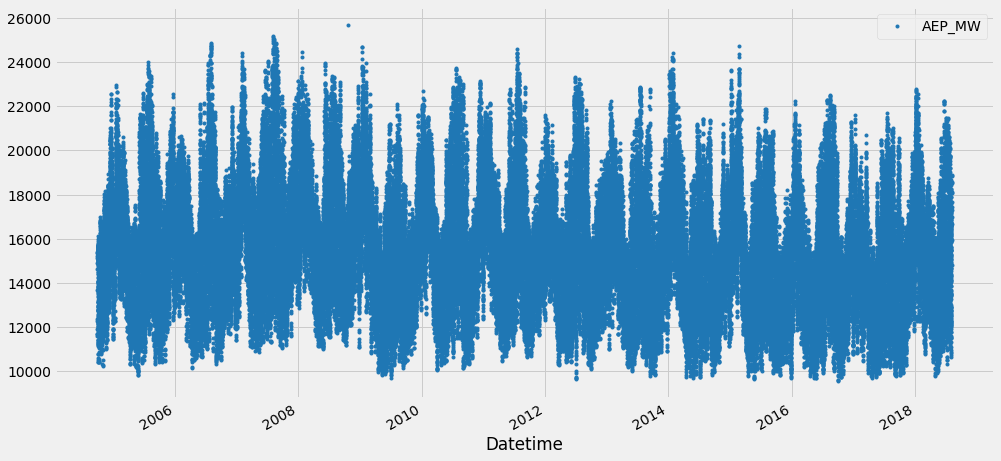

In [9]:
df.plot(style=".", 
        figsize=(15, 8), 
        color=color_pal[0])

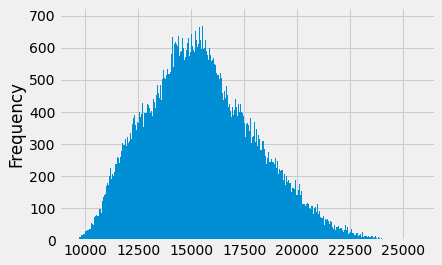

In [10]:
'''
remove outlier
'''

df['AEP_MW'].plot(kind='hist', bins=500)

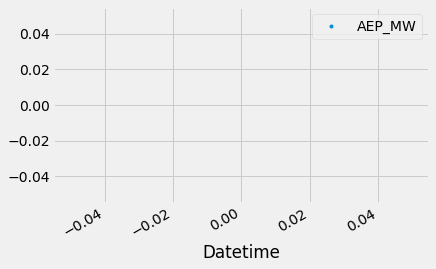

In [11]:
df.query('AEP_MW < 9_500').plot(style='.')

In [12]:
df = df.query('AEP_MW > 9_500').copy()

In [13]:
#train test split

In [14]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [15]:
train

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2014-01-01 20:00:00,16433.0
2014-01-01 21:00:00,16376.0
2014-01-01 22:00:00,16151.0


In [16]:
test

,AEP_MW
Datetime,
2015-01-01 00:00:00,16375.0
2015-12-31 01:00:00,12415.0
2015-12-31 02:00:00,12087.0
2015-12-31 03:00:00,12010.0
2015-12-31 04:00:00,11972.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


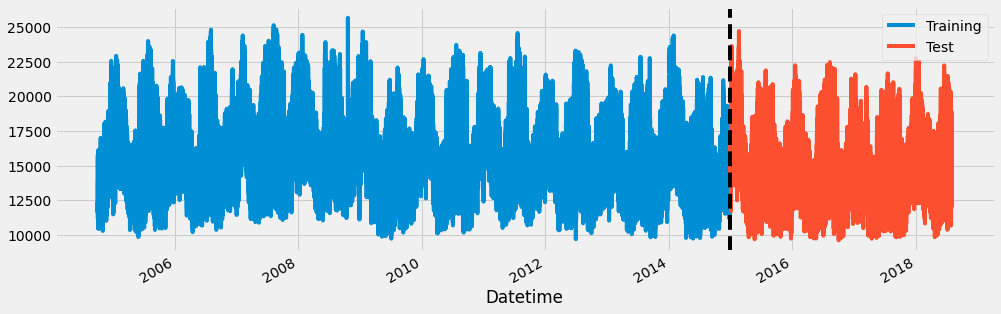

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training', 'Test'])

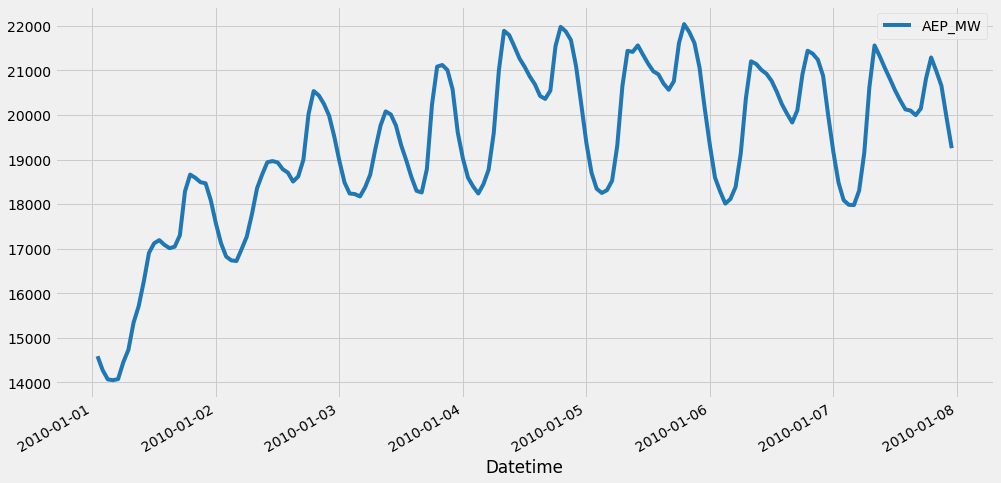

In [18]:


df[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(style="-", 
        figsize=(15, 8), 
        color=color_pal[0])

In [19]:
#feature creations

In [20]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() #needed for the split

In [21]:
df.columns

Index(['AEP_MW'], dtype='object')

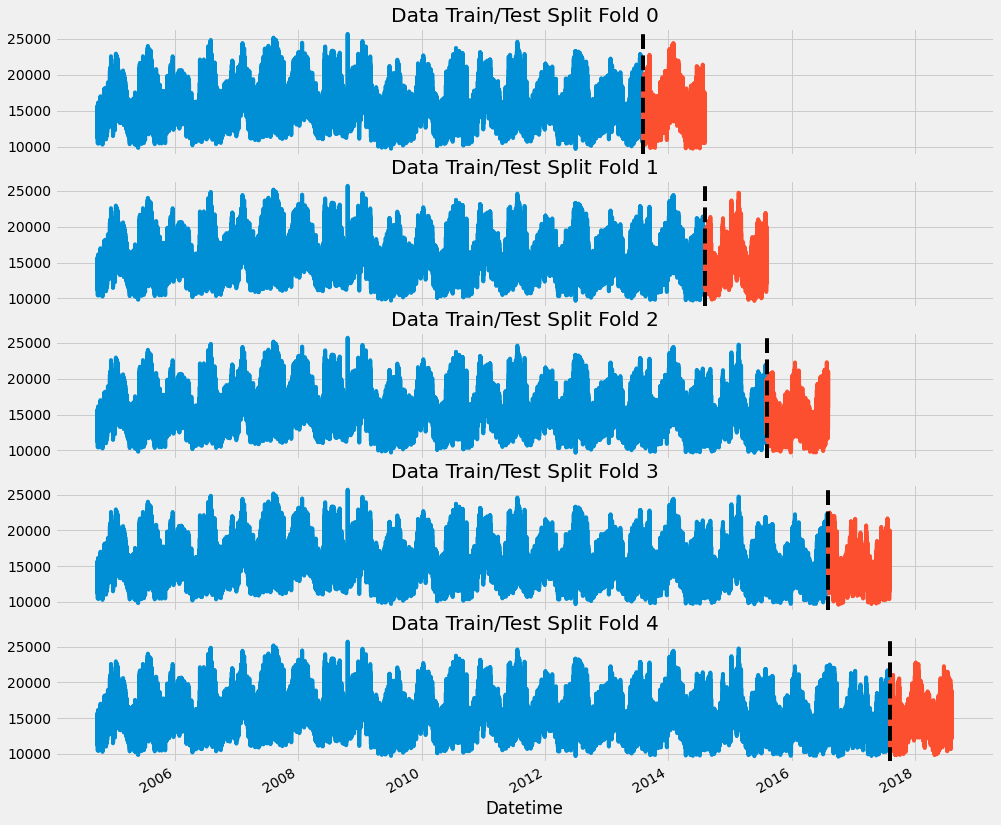

In [22]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()


In [23]:
'''
forecast horizon
'''

'\nforecast horizon\n'

In [51]:
def create_features(df):

  df = df.copy()
  df['hour'] = df.index.hour
  df['day_of_week'] = df.index.day_of_week
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['day_of_year'] = df.index.dayofyear

  return df

In [25]:
df = create_features(df)

In [26]:
'''
lag features
'''

'\nlag features\n'

In [27]:
df.index - pd.Timedelta('364 days')

DatetimeIndex(['2003-10-03 01:00:00', '2003-10-03 02:00:00',
               '2003-10-03 03:00:00', '2003-10-03 04:00:00',
               '2003-10-03 05:00:00', '2003-10-03 06:00:00',
               '2003-10-03 07:00:00', '2003-10-03 08:00:00',
               '2003-10-03 09:00:00', '2003-10-03 10:00:00',
               ...
               '2017-08-03 15:00:00', '2017-08-03 16:00:00',
               '2017-08-03 17:00:00', '2017-08-03 18:00:00',
               '2017-08-03 19:00:00', '2017-08-03 20:00:00',
               '2017-08-03 21:00:00', '2017-08-03 22:00:00',
               '2017-08-03 23:00:00', '2017-08-04 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=121273, freq=None)

In [28]:
def add_lags(df):

  target_map = df['AEP_MW'].to_dict()

  df = df.copy()
  df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
  df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
  df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

  return df

In [29]:
df = add_lags(df)

In [30]:
df

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3
Datetime,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17544.0,19246.0,15783.0


In [31]:
'''
visualize feature to target visualization
'''

'\nvisualize feature to target visualization\n'

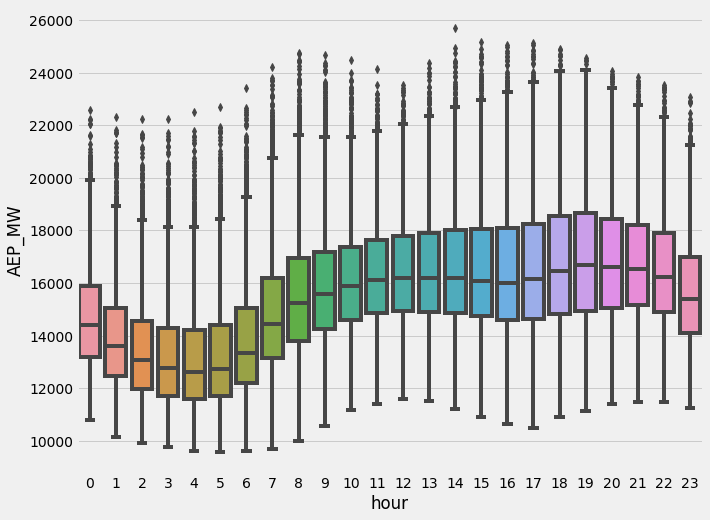

In [32]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df,
            x='hour',
            y='AEP_MW')

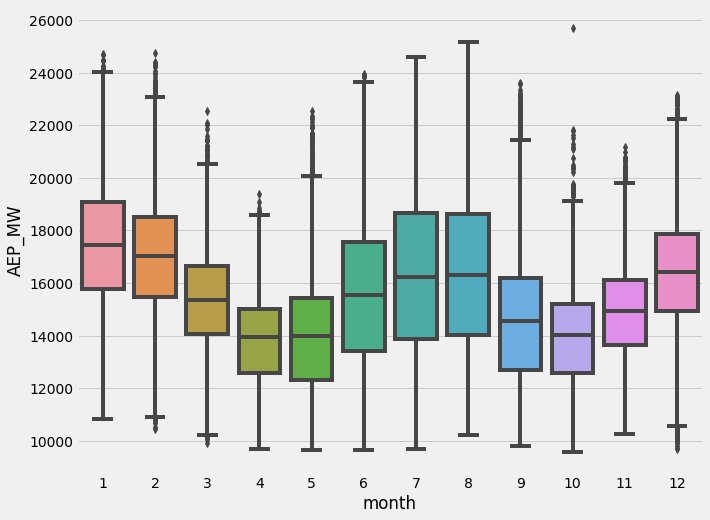

In [33]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df,
            x='month',
            y='AEP_MW')

In [34]:
#create our model

In [35]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index() #needed for the split

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(df):

  train = df.iloc[train_idx]
  test = df.iloc[val_idx]

  train = create_features(train)
  test = create_features(test)

  features = [ 'hour', 'day_of_week', 'quarter', 'month', 'year','day_of_year',
               'lag1','lag2','lag3']
               
  target = 'AEP_MW'

  X_train = train[features]
  y_train = train[target]

  X_test = test[features]
  y_test = test[target]

  reg = xgb.XGBRegressor(base_score=0.5,
                         booster='gbtree',
                         objective='reg:squarederror',
                         max_depth=3,
                         n_estimators=1_000, 
                         early_stopping_rounds=50, 
                         learning_rate=0.01)
  
  reg.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)
  
  y_pred = reg.predict(X_test)
  preds.append(y_pred)
  score = np.sqrt(mean_squared_error(y_test, y_pred))
  scores.append(score)

[0]	validation_0-rmse:15898.4	validation_1-rmse:15264.2
[100]	validation_0-rmse:6031.36	validation_1-rmse:5643.86
[200]	validation_0-rmse:2654.7	validation_1-rmse:2428.44
[300]	validation_0-rmse:1710.06	validation_1-rmse:1641.71
[400]	validation_0-rmse:1490.7	validation_1-rmse:1550.9
[500]	validation_0-rmse:1429.34	validation_1-rmse:1559.77
[600]	validation_0-rmse:1397.59	validation_1-rmse:1557.37
[700]	validation_0-rmse:1377.01	validation_1-rmse:1543.72
[800]	validation_0-rmse:1363.81	validation_1-rmse:1542.82
[900]	validation_0-rmse:1344.32	validation_1-rmse:1543.63
[999]	validation_0-rmse:1328.24	validation_1-rmse:1552
[0]	validation_0-rmse:15835.5	validation_1-rmse:15222
[100]	validation_0-rmse:6007.69	validation_1-rmse:5713.79
[200]	validation_0-rmse:2646.05	validation_1-rmse:2507.82
[300]	validation_0-rmse:1708.08	validation_1-rmse:1618.8
[400]	validation_0-rmse:1501.4	validation_1-rmse:1455.29
[500]	validation_0-rmse:1442.45	validation_1-rmse:1430.1
[600]	validation_0-rmse:1410.

In [36]:
print(np.mean(scores))
print(scores)

1594.6122061867775
[1552.0025036538432, 1436.34615566268, 1592.4274932365668, 1653.4615961093268, 1738.8232822714697]


In [37]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=X_train.columns,
             columns=['impo'])

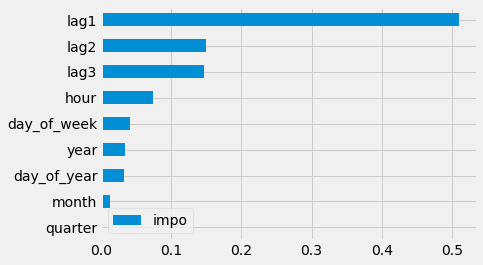

In [38]:
fi.sort_values('impo').plot(kind='barh')

In [39]:
#forecast

test['prediction'] = reg.predict(X_test)

In [40]:
test

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,prediction
Datetime,,,,,,,,,,,
2017-08-03 01:00:00,13682.0,1,3,3,8,2017,215,15045.0,13766.0,13230.0,13917.830078
2017-08-03 02:00:00,12841.0,2,3,3,8,2017,215,14258.0,13034.0,12648.0,13257.282227
2017-08-03 03:00:00,12443.0,3,3,3,8,2017,215,13758.0,12631.0,12124.0,12954.673828
2017-08-03 04:00:00,12213.0,4,3,3,8,2017,215,13330.0,12467.0,11929.0,12718.930664
2017-08-03 05:00:00,12286.0,5,3,3,8,2017,215,13257.0,12474.0,11851.0,12656.256836
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18705.0,20140.0,16078.0,18098.943359
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18108.0,19616.0,15908.0,17953.388672
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17544.0,19246.0,15783.0,17747.978516


In [ ]:
#predict
#train one final all time


In [41]:
 
X_train = df[features]
y_train = df[target]
 
reg = xgb.XGBRegressor(base_score=0.5,
                        booster='gbtree',
                        objective='reg:squarederror',
                        max_depth=3,
                        n_estimators=500, 
                        early_stopping_rounds=50, 
                        learning_rate=0.01)
  
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        verbose=100)

[0]	validation_0-rmse:15559
[100]	validation_0-rmse:5908.63
[200]	validation_0-rmse:2621.94
[300]	validation_0-rmse:1721.46
[400]	validation_0-rmse:1524.55
[499]	validation_0-rmse:1472.38


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=500,
             objective='reg:squarederror')

In [42]:
df

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3
Datetime,,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,18705.0,20140.0,16078.0
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,18108.0,19616.0,15908.0
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,17544.0,19246.0,15783.0


In [43]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [48]:
future = pd.date_range('2018-08-03', '2019-08-01', freq = '1h')
future_df = pd.DataFrame(index=future)

future_df['isFuture'] = True

In [49]:
df['isFuture'] = False

In [55]:
df_and_future = pd.concat([df, future_df])

In [56]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [57]:
df_and_future

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,isFuture
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,NaN,NaN,NaN,False
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,15259.0,16100.0,17790.0,True


In [58]:
future_w_features = df_and_future.query('isFuture').copy()

In [59]:
future_w_features

,AEP_MW,hour,day_of_week,quarter,month,year,day_of_year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,15045.0,16491.0,13669.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,13940.0,15319.0,12772.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,13230.0,14492.0,12253.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,12624.0,13945.0,11928.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,12410.0,13619.0,11696.0,True
...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,16579.0,18495.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,16457.0,17771.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,16197.0,17220.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,15259.0,16100.0,17790.0,True


In [60]:
#predict

In [69]:
future_w_features['pred'] = reg.predict(future_w_features[features])

Text(0.5, 1.0, 'Raw Data')

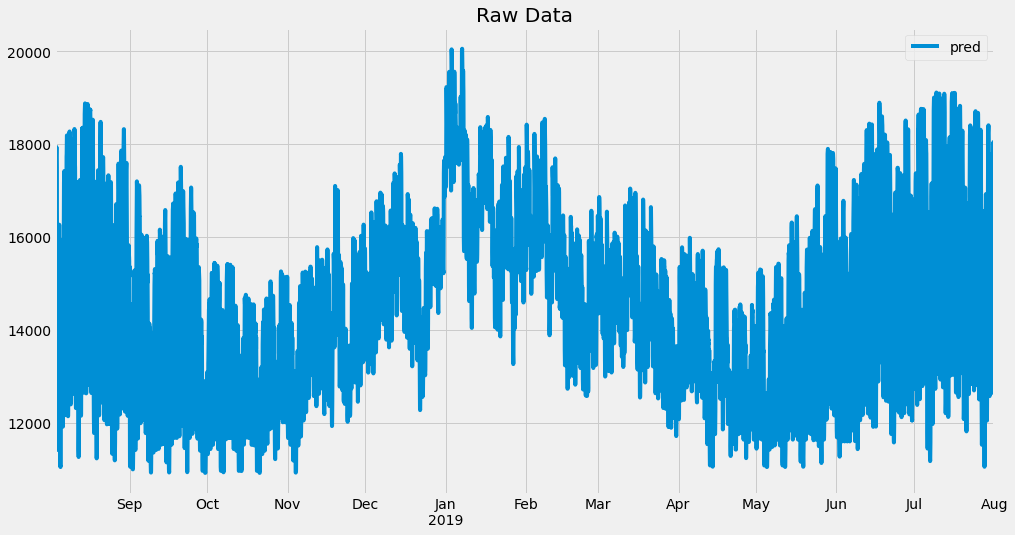

In [70]:
ax = future_w_features[['pred']].plot(figsize=(15, 8))
ax.set_title('Raw Data')


In [ ]:
'''
save model
'''

In [65]:
reg.save_model('model.json')

In [67]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('/content/model.json')

In [68]:
reg_new

XGBRegressor()

In [42]:
df = df.merge(test[['prediction']],
              how='left',
              left_index=True,
              right_index=True)

Text(0.5, 1.0, 'Raw Data')

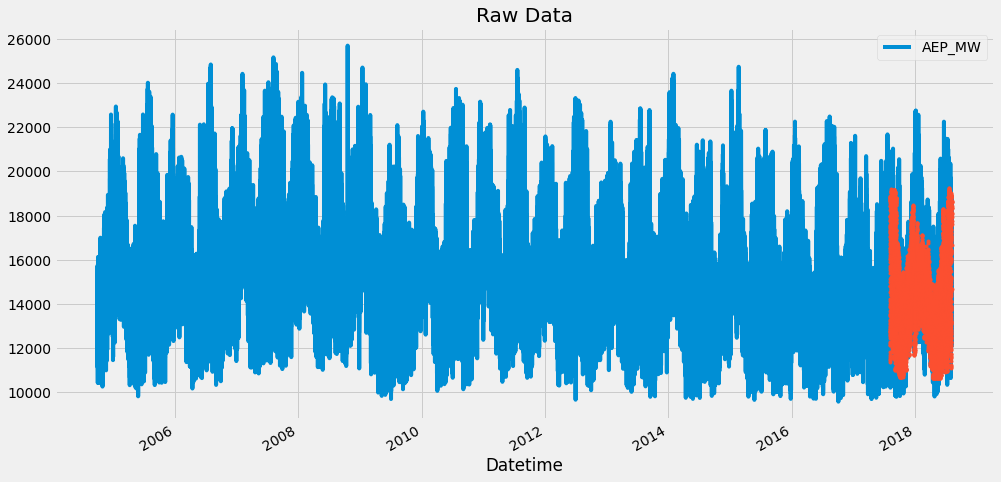

In [43]:
ax = df[['AEP_MW']].plot(figsize=(15, 8))
df['prediction'].plot(ax=ax, style=".")
ax.set_title('Raw Data')


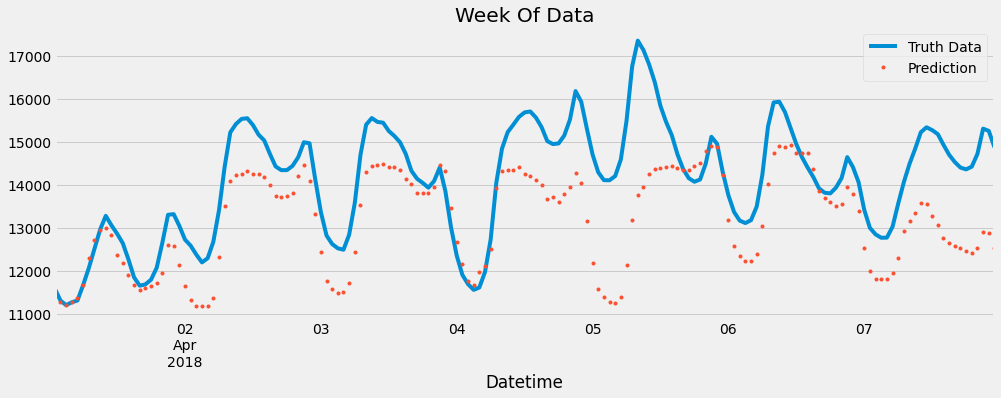

In [44]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [73]:
'''
eval
'''

'\neval\n'

In [79]:
score = np.sqrt(mean_squared_error(y_test, test['prediction']))
print(score)

1656.8250447416747


In [ ]:
'''
calculate error
'''

In [83]:
test['error'] = np.abs(test[target] - test['prediction'])

In [1]:
'''

'''

'\nsecond class\n'